In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
%cd /content/drive/MyDrive/coyote_pj

/content/drive/MyDrive/coyote_pj


In [3]:
# !unzip -qq COYOTE-final.zip

## Import module

In [4]:
import librosa 
import librosa.display as dsp
from IPython.display import Audio

In [5]:
import pandas as pd
import numpy as np
from tqdm import tqdm
import os

In [6]:
import torch
import torchvision.datasets as datasets 
import torchvision.transforms as transforms  
from torch.utils.data import DataLoader 
from torch.utils.data import DataLoader, Dataset

import torch.optim as optim  

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu') 
print(device)

cuda


## Hyper-parameter Setting

In [7]:
mini = 7296
num_epochs = 100
batch_size = 10
learning_rate = 1e-3
print(f'epoch : {num_epochs} \n batch : {batch_size} \n lr : {learning_rate}')

epoch : 100 
 batch : 10 
 lr : 0.001


## Dataset & DataLoader

In [8]:
class CustomDataset(Dataset):
    def __init__(self, file_path, train_mode=True, transforms=None): 
        self.csv = pd.read_csv(file_path)
        self.train_mode = train_mode
        self.transforms = transforms

    def __len__(self): 
        # return 10 #DEBUG
        return self.csv.shape[0]
    
    def __getitem__(self, index): 
        file_name = self.csv.iloc[index].file_name
        audio, sr = librosa.load(f'/content/drive/MyDrive/coyote_pj/data/dataset_all/{file_name}', sr = 16000)
        audio = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=40)  
        audio = np.array(audio)
        audio = audio.reshape(audio.shape[0], audio.shape[1], 1)  
        
        label = self.csv.iloc[index].label
        # label = classes[label]
        
        if self.transforms is not None:  
            audio = self.transforms(audio)

        return audio, label  

In [9]:
train_dataset = CustomDataset('./train.csv', train_mode = True, transforms = None) # *****
train_loader = DataLoader(train_dataset, batch_size = batch_size, shuffle=True, num_workers=2)

vali_dataset = CustomDataset('./valid.csv', train_mode = False, transforms = None)
vali_loader = DataLoader(vali_dataset, batch_size = batch_size, shuffle=False, num_workers=2)

In [10]:
train_batches = len(train_loader)
vali_batches = len(vali_loader)

print('/ total train batches :', train_batches)
print('/ total valid batches :', vali_batches)

/ total train batches : 116
/ total valid batches : 28


## Model design

In [11]:
from tqdm.auto import tqdm
import torch.nn as nn  

class CNNclassification(torch.nn.Module):
    def __init__(self):
        super(CNNclassification, self).__init__()
        self.layer1 = torch.nn.Sequential(
            nn.Conv2d(40, 10, kernel_size=2, stride=1, padding=1), #cnn layer
            nn.ReLU(), #activation function
            nn.MaxPool2d(kernel_size=2, stride=2)) #pooling layer
        
        self.layer2 = torch.nn.Sequential(
            nn.Conv2d(10, 100, kernel_size=2, stride=1, padding=1), #cnn layer
            nn.ReLU(), #activation function
            nn.MaxPool2d(kernel_size=2, stride=2)) #pooling layer
        
        self.layer3 = torch.nn.Sequential(
            nn.Conv2d(100, 200, kernel_size=2, stride=1, padding=1), #cnn layer
            nn.ReLU(), #activation function
            nn.MaxPool2d(kernel_size=2, stride=2)) #pooling layer
        
        self.layer4 = torch.nn.Sequential(
            nn.Conv2d(200, 300, kernel_size=2, stride=1, padding=1), #cnn layer
            nn.ReLU(), #activation function
            nn.MaxPool2d(kernel_size=2, stride=2)) #pooling layer
        
        self.fc_layer = nn.Sequential( 
            nn.Linear(4000, 2) #fully connected layer(ouput layer) 
        )    
        
    def forward(self, x):
        
        x = self.layer1(x)  
        
        x = self.layer2(x) 
         
        x = self.layer3(x) 
               
        x = torch.flatten(x, start_dim=1)  

        out = self.fc_layer(x)
        return out

## Traning Model

In [12]:
model = CNNclassification().to(device)
criterion = torch.nn.CrossEntropyLoss().to(device)
# optimizer = torch.optim.SGD(params = model.parameters(), lr = 1e-3 )
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
scheduler = None # ****** scheduler

# scheduler_cosine = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, args.n_epochs - 1)
# scheduler_warmup = GradualWarmupSchedulerV2(optimizer, multiplier=10, total_epoch=1, after_scheduler=scheduler_cosine)

In [13]:
# model(torch.rand(10, 40, 12, 1).to(device))

In [14]:
from tqdm.auto import tqdm

import torch.nn.functional as F
def train(model, optimizer, train_loader, scheduler, device): 
    model.to(device)
    n = len(train_loader)
    best_loss = np.inf
    
    for epoch in range(1,num_epochs): 
        model.train()  
        running_loss = 0.0        
        
        for wav, label in tqdm(iter(train_loader)):
            wav, label = wav.to(device), label.to(device) 
            optimizer.zero_grad()  
        
            # Data -> Model -> Output
            logit = model(wav)  
            ps = F.softmax(logit, dim=1)  
            loss = criterion(logit, label)  
             
            loss.backward() 
            optimizer.step()  
            running_loss += loss.item()
        print(f'-----  Epoch {epoch} -----')     
        print('Train loss: %.10f' %(running_loss / len(train_loader)))
        
        if scheduler is not None:
            scheduler.step()
            
             
        model.eval()  
        vali_loss = 0.0
        correct = 0

        real_list = []
        pred_list = []
               
        with torch.no_grad():  
            for wav, label in tqdm(iter(vali_loader)):
                
                wav, label = wav.to(device), label.to(device)
                logit = model(wav)
                vali_loss += criterion(logit, label)
                # print(logit)
                pred = logit.argmax(dim=1, keepdim=False) 
                correct += pred.eq(label.view_as(pred)).sum().item() 
                real_list.extend(label.cpu().tolist())
                pred_list.extend(pred.cpu().tolist())
            print(real_list)
            print(pred_list)
            tmp = real_list == pred_list
            # print(tmp)
            print('acc : ', (tmp / len(real_list)) * 100)


        vali_acc = 100 * correct / len(vali_loader.dataset)
        vali_loss_total = vali_loss / len(vali_loader)
        print('Vail set: Loss: {:.4f}, Accuracy: {}/{} ( {:.0f}%)\n'.format(vali_loss / len(vali_loader), correct, len(vali_loader.dataset), 100 * correct / len(vali_loader.dataset)))

        if best_loss > vali_loss_total:
            best_loss = vali_loss_total
            torch.save(model.state_dict(), './best_model_sr(16000).pth')  
            print('Model Saved.')

In [15]:
# train(model, optimizer, train_loader, scheduler, device)

In [16]:
best_model = CNNclassification().to(device)
best_model.load_state_dict(torch.load('/content/drive/MyDrive/coyote_pj/best_model_sr(16000).pth', map_location=torch.device('cpu')))

vali_dataset = CustomDataset('./valid.csv', train_mode = False, transforms = None)
vali_loader = DataLoader(vali_dataset, batch_size = batch_size, shuffle=False, num_workers=2)

In [17]:
best_model.eval() 
vali_loss = 0.0
correct = 0

real_list = []
pred_list = []
prob_list = []

with torch.no_grad():  
    for wav, label in tqdm(iter(vali_loader)):
        
        wav, label = wav.to(device), label.to(device)
        logit = best_model(wav)
        vali_loss += criterion(logit, label)

        ps = F.softmax(logit, dim=1)
        # top_p, top_class = ps.topk(1, dim=1)

        pred = logit.argmax(dim=1, keepdim=False)   
        correct += pred.eq(label.view_as(pred)).sum().item()  
        real_list.extend(label.cpu().tolist())
        pred_list.extend(pred.cpu().tolist())
        prob_list.extend(ps.cpu().tolist())

print(real_list)
print(pred_list)

vali_acc = 100 * correct / len(vali_loader.dataset)
vali_loss_total = vali_loss / len(vali_loader)
print('Vail set: Loss: {:.4f}, Accuracy: {}/{} ( {:.0f}%)\n'.format(vali_loss / len(vali_loader), correct, len(vali_loader.dataset), 100 * correct / len(vali_loader.dataset)))

  0%|          | 0/28 [00:00<?, ?it/s]

[0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1]
[0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0,

### Confusion Matrix & ROC curve

In [18]:
real_list = np.array(np.int64(real_list))
pred_list = np.array(np.int64(pred_list))

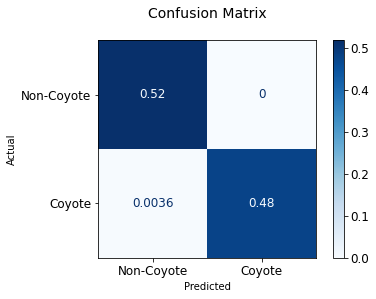

In [19]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay 

cm = confusion_matrix(pred_list, real_list, normalize='all') 
plt.rcParams.update({'font.size': 12})
cmd = ConfusionMatrixDisplay(cm, display_labels=['Non-Coyote','Coyote'])
cmd.plot(cmap=plt.cm.Blues)
cmd.ax_.set_title('Confusion Matrix\n',fontsize = 14)
plt.xlabel('Predicted', fontsize=10)
plt.ylabel('Actual', fontsize=10, rotation = 90)
plt.savefig(f'/content/drive/MyDrive/coyote_pj/confusion_mat') 
plt.show()


In [20]:
!pip install scikit-plot

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; This will be removed in v0.5.0. Please use scikitplot.metrics.plot_roc instead.
  warnings.warn(msg, category=FutureWarning)


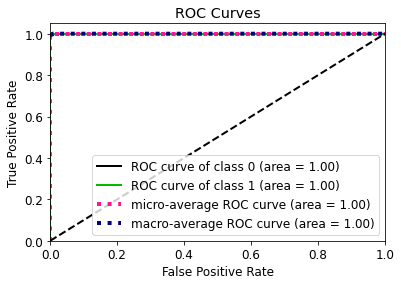

In [21]:
import scikitplot as skplt
import matplotlib.pyplot as plt

y_true = real_list # ground truth labels
y_probas = prob_list # predicted probabilities generated by sklearn classifier
skplt.metrics.plot_roc_curve(real_list, prob_list)
plt.savefig(f'/content/drive/MyDrive/coyote_pj/roc') 
plt.show()

In [22]:
from sklearn.metrics import classification_report
print(classification_report(real_list, pred_list, target_names=['coyote', 'non-coyote']))

              precision    recall  f1-score   support

      coyote       1.00      0.99      1.00       146
  non-coyote       0.99      1.00      1.00       134

    accuracy                           1.00       280
   macro avg       1.00      1.00      1.00       280
weighted avg       1.00      1.00      1.00       280

